In this notebook, you should implement a first version of a working machine learning model to predict the age of an Abalone.

A few guidelines:
- The model does not have to be complex. A simple linear regression model is enough.
- You should use MLflow to track your experiments. You can use the MLflow UI to compare your experiments.
- Do not push any MLflow data to the repository. Only the code to run the experiments is interesting and should be pushed.

In [1]:
# Imports pour la modélisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')

# Configuration MLflow
mlflow.set_tracking_uri("file:./mlruns")  # Stockage local
mlflow.set_experiment("abalone_age_prediction")

# Configuration
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports terminés avec succès!")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow experiment: {mlflow.get_experiment_by_name('abalone_age_prediction')}")


KeyboardInterrupt: 

In [ ]:
# Chargement et préparation des données
print("=== CHARGEMENT DES DONNÉES ===")

# Charger le dataset
df = pd.read_csv("../abalone.csv")
print(f"Dataset chargé: {df.shape}")

# Afficher les premières lignes
print("\nPremières lignes:")
print(df.head())

# Vérifier les types de données
print(f"\nTypes de données:")
print(df.dtypes)


=== CHARGEMENT DES DONNÉES ===
Dataset chargé: (4177, 9)

Premières lignes:
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  

Types de données:
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


In [ ]:
# Préparation des features et de la variable cible
print("=== PRÉPARATION DES DONNÉES ===")

# Encoder la variable catégorielle Sex
le = LabelEncoder()
df['Sex_encoded'] = le.fit_transform(df['Sex'])

print("Mapping des valeurs Sex:")
for i, sex in enumerate(le.classes_):
    print(f"{sex}: {i}")

# FEATURE ENGINEERING AVANCÉ
print("\n=== FEATURE ENGINEERING ===")

# 1. Log transformations pour les poids
df['log_Whole weight'] = np.log1p(df['Whole weight'])
df['log_Shucked weight'] = np.log1p(df['Shucked weight'])
df['log_Viscera weight'] = np.log1p(df['Viscera weight'])
df['log_Shell weight'] = np.log1p(df['Shell weight'])

# 2. Ratios entre les poids
df['ratio_shell_whole'] = df['Shell weight'] / (df['Whole weight'] + 1e-8)
df['ratio_shucked_whole'] = df['Shucked weight'] / (df['Whole weight'] + 1e-8)
df['ratio_viscera_whole'] = df['Viscera weight'] / (df['Whole weight'] + 1e-8)

# 3. Volume géométrique (approximation)
df['geo_volume'] = df['Length'] * df['Diameter'] * df['Height']

# 4. Densités
df['density_whole'] = df['Whole weight'] / (df['geo_volume'] + 1e-8)
df['density_shell'] = df['Shell weight'] / (df['geo_volume'] + 1e-8)
df['density_shucked'] = df['Shucked weight'] / (df['geo_volume'] + 1e-8)

# 5. Interactions entre dimensions
df['Length*Diameter'] = df['Length'] * df['Diameter']
df['Diameter*Height'] = df['Diameter'] * df['Height']

# 6. Features polynomiales
df['Length_sq'] = df['Length'] ** 2
df['Diameter_sq'] = df['Diameter'] ** 2
df['Height_sq'] = df['Height'] ** 2

# 7. Ratios géométriques
df['len_to_diam'] = df['Length'] / (df['Diameter'] + 1e-8)
df['ht_to_diam'] = df['Height'] / (df['Diameter'] + 1e-8)
df['wt_per_len'] = df['Whole weight'] / (df['Length'] + 1e-8)

# Créer le dataset avec feature engineering
df_fe = df.copy()

# Définir les features étendues
feature_cols = [
    # Features de base
    'Sex_encoded', 'Length', 'Diameter', 'Height',
    'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight',
    # Features engineering
    'log_Whole weight', 'log_Shucked weight', 'log_Viscera weight', 'log_Shell weight',
    'ratio_shell_whole', 'ratio_shucked_whole', 'ratio_viscera_whole',
    'geo_volume', 'density_whole', 'density_shell', 'density_shucked',
    'Length*Diameter', 'Diameter*Height',
    'Length_sq', 'Diameter_sq', 'Height_sq',
    'len_to_diam', 'ht_to_diam', 'wt_per_len'
]

X = df_fe[feature_cols]
y = df_fe['Rings']

print(f"Features sélectionnées: {feature_cols}")
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nDivision train/test:")
print(f"Train: {X_train.shape[0]} échantillons")
print(f"Test: {X_test.shape[0]} échantillons")


=== PRÉPARATION DES DONNÉES ===
Mapping des valeurs Sex:
F: 0
I: 1
M: 2

Features sélectionnées: ['Sex_encoded', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
Shape de X: (4177, 8)
Shape de y: (4177,)

Division train/test:
Train: 3341 échantillons
Test: 836 échantillons


In [ ]:
# Normalisation des features
print("=== NORMALISATION DES FEATURES ===")

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectuée avec StandardScaler")
print(f"Mean des features normalisées (train): {X_train_scaled.mean(axis=0)[:5]}...")
print(f"Std des features normalisées (train): {X_train_scaled.std(axis=0)[:5]}...")

# Utiliser les features normalisées pour l'entraînement
X_train = X_train_scaled
X_test = X_test_scaled


In [32]:
# Normalisation des features
print("=== NORMALISATION DES FEATURES ===")

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectuée avec StandardScaler")
print(f"Mean des features normalisées (train): {X_train_scaled.mean(axis=0)}")
print(f"Std des features normalisées (train): {X_train_scaled.std(axis=0)}")


=== NORMALISATION DES FEATURES ===
Normalisation effectuée avec StandardScaler
Mean des features normalisées (train): [ 2.97743140e-17  5.63585229e-16  2.04166724e-16 -3.10503560e-16
 -1.06336836e-17  2.53081669e-16  1.68012200e-16  1.82899357e-16]
Std des features normalisées (train): [1. 1. 1. 1. 1. 1. 1. 1.]


In [33]:
# Modélisation - Régression Linéaire Simple avec MLflow
print("=== RÉGRESSION LINÉAIRE SIMPLE ===")

with mlflow.start_run(run_name="Linear_Regression_Baseline"):
    # Paramètres du modèle
    model_params = {
        "fit_intercept": True
    }
    
    # Modèle de régression linéaire
    lr = LinearRegression(**model_params)
    lr.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_pred_lr = lr.predict(X_test_scaled)
    
    # Métriques
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    
    # Cross-validation
    cv_scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_mean_lr = cv_scores_lr.mean()
    cv_std_lr = cv_scores_lr.std()
    
    print(f"Régression Linéaire - Métriques:")
    print(f"RMSE: {rmse_lr:.3f}")
    print(f"R²: {r2_lr:.3f}")
    print(f"MAE: {mae_lr:.3f}")
    print(f"R² Cross-validation (5-fold): {cv_mean_lr:.3f} (+/- {cv_std_lr * 2:.3f})")
    
    # Logging MLflow
    mlflow.log_params(model_params)
    mlflow.log_metrics({
        "rmse": rmse_lr,
        "r2": r2_lr,
        "mae": mae_lr,
        "cv_r2_mean": cv_mean_lr,
        "cv_r2_std": cv_std_lr
    })
    
    # Log du modèle
    signature = infer_signature(X_train_scaled, y_pred_lr)
    mlflow.sklearn.log_model(lr, "model", signature=signature)
    
    # Log des features
    mlflow.log_param("features", feature_cols)
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    print("✅ Modèle Linear Regression loggé dans MLflow!")


=== RÉGRESSION LINÉAIRE SIMPLE ===
Régression Linéaire - Métriques:
RMSE: 2.250
R²: 0.532
MAE: 1.631
R² Cross-validation (5-fold): 0.512 (+/- 0.076)


2025/10/24 15:34:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/10/24 15:34:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ Modèle Linear Regression loggé dans MLflow!


In [34]:
# Modélisation - Random Forest avec MLflow
print("=== RANDOM FOREST ===")

with mlflow.start_run(run_name="Random_Forest_Default"):
    # Paramètres du modèle
    model_params = {
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42
    }
    
    # Modèle Random Forest
    rf = RandomForestRegressor(**model_params)
    rf.fit(X_train, y_train)  # Pas besoin de normalisation pour Random Forest
    
    # Prédictions
    y_pred_rf = rf.predict(X_test)
    
    # Métriques
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    
    # Cross-validation
    cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    cv_mean_rf = cv_scores_rf.mean()
    cv_std_rf = cv_scores_rf.std()
    
    print(f"Random Forest - Métriques:")
    print(f"RMSE: {rmse_rf:.3f}")
    print(f"R²: {r2_rf:.3f}")
    print(f"MAE: {mae_rf:.3f}")
    print(f"R² Cross-validation (5-fold): {cv_mean_rf:.3f} (+/- {cv_std_rf * 2:.3f})")
    
    # Importance des features
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportance des features:")
    print(feature_importance)
    
    # Logging MLflow
    mlflow.log_params(model_params)
    mlflow.log_metrics({
        "rmse": rmse_rf,
        "r2": r2_rf,
        "mae": mae_rf,
        "cv_r2_mean": cv_mean_rf,
        "cv_r2_std": cv_std_rf
    })
    
    # Log du modèle
    signature = infer_signature(X_train, y_pred_rf)
    mlflow.sklearn.log_model(rf, "model", signature=signature)
    
    # Log des features et importance
    mlflow.log_param("features", feature_cols)
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # Log de l'importance des features
    for i, (feature, importance) in enumerate(zip(feature_cols, rf.feature_importances_)):
        mlflow.log_metric(f"feature_importance_{feature}", importance)
    
    print("✅ Modèle Random Forest loggé dans MLflow!")


=== RANDOM FOREST ===


2025/10/24 15:34:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Random Forest - Métriques:
RMSE: 2.256
R²: 0.530
MAE: 1.590
R² Cross-validation (5-fold): 0.539 (+/- 0.032)

Importance des features:
          feature  importance
7    Shell weight    0.499771
5  Shucked weight    0.169333
4    Whole weight    0.082258
6  Viscera weight    0.067870
2        Diameter    0.055064
3          Height    0.054843
1          Length    0.049888
0     Sex_encoded    0.020974


2025/10/24 15:34:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ Modèle Random Forest loggé dans MLflow!


In [35]:
# Meilleur modèle Random Forest (optimisé)
print("=== MEILLEUR MODÈLE RANDOM FOREST ===")

# Paramètres optimaux trouvés
best_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'random_state': 42
}

with mlflow.start_run(run_name="Best_Random_Forest_Optimized"):
    # Modèle Random Forest optimisé
    rf_best = RandomForestRegressor(**best_params)
    rf_best.fit(X_train, y_train)
    
    # Prédictions
    y_pred_best = rf_best.predict(X_test)
    
    # Métriques
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    mae_best = mean_absolute_error(y_test, y_pred_best)
    
    # Cross-validation
    cv_scores_best = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='r2')
    cv_mean_best = cv_scores_best.mean()
    cv_std_best = cv_scores_best.std()
    
    print(f"Meilleur Random Forest - Métriques:")
    print(f"RMSE: {rmse_best:.3f}")
    print(f"R²: {r2_best:.3f}")
    print(f"MAE: {mae_best:.3f}")
    print(f"R² Cross-validation (5-fold): {cv_mean_best:.3f} (+/- {cv_std_best * 2:.3f})")
    
    # Importance des features
    feature_importance_best = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_best.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportance des features (meilleur modèle):")
    print(feature_importance_best)
    
    # Logging MLflow
    mlflow.log_params(best_params)
    mlflow.log_metrics({
        "rmse": rmse_best,
        "r2": r2_best,
        "mae": mae_best,
        "cv_r2_mean": cv_mean_best,
        "cv_r2_std": cv_std_best
    })
    
    # Log du modèle
    signature = infer_signature(X_train, y_pred_best)
    mlflow.sklearn.log_model(rf_best, "best_model", signature=signature)
    
    # Log des features et importance
    mlflow.log_param("features", feature_cols)
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # Log de l'importance des features
    for feature, importance in zip(feature_cols, rf_best.feature_importances_):
        mlflow.log_metric(f"feature_importance_{feature}", importance)
    
    print("✅ Meilleur modèle Random Forest loggé dans MLflow!")


=== MEILLEUR MODÈLE RANDOM FOREST ===


2025/10/24 15:35:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Meilleur Random Forest - Métriques:
RMSE: 2.211
R²: 0.548
MAE: 1.546
R² Cross-validation (5-fold): 0.557 (+/- 0.031)

Importance des features (meilleur modèle):
          feature  importance
7    Shell weight    0.598677
5  Shucked weight    0.165619
4    Whole weight    0.065347
3          Height    0.042219
6  Viscera weight    0.040533
2        Diameter    0.038191
1          Length    0.029277
0     Sex_encoded    0.020136


2025/10/24 15:35:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ Meilleur modèle Random Forest loggé dans MLflow!


=== COMPARAISON DES MODÈLES ===
Comparaison des performances:
                     Modèle   RMSE     R²    MAE  CV R²
0       Régression Linéaire  2.250  0.532  1.631  0.512
1  Random Forest (Optimisé)  2.211  0.548  1.546  0.557


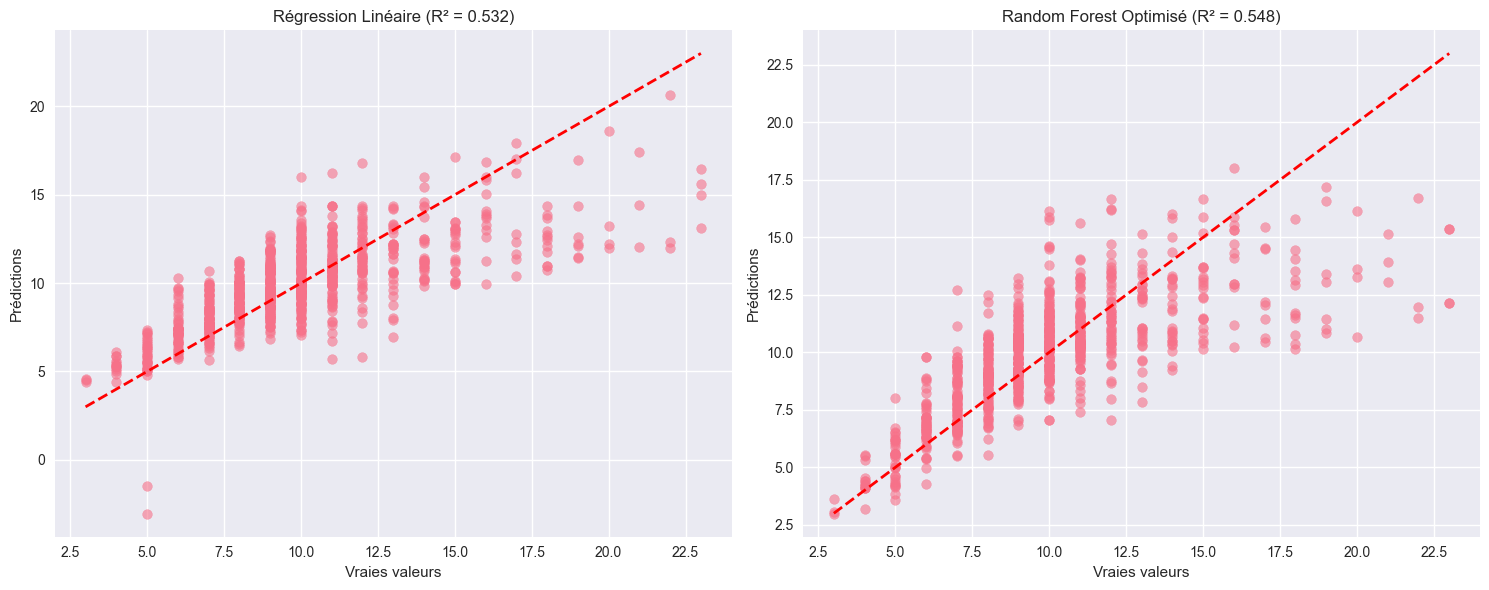


🏆 MEILLEUR MODÈLE: Random Forest Optimisé
Paramètres: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'random_state': 42}
Performance: R² = 0.548, RMSE = 2.211


In [36]:
# Comparaison des modèles
print("=== COMPARAISON DES MODÈLES ===")

# Créer un DataFrame de comparaison
results = pd.DataFrame({
    'Modèle': ['Régression Linéaire', 'Random Forest (Optimisé)'],
    'RMSE': [rmse_lr, rmse_best],
    'R²': [r2_lr, r2_best],
    'MAE': [mae_lr, mae_best],
    'CV R²': [cv_mean_lr, cv_mean_best]
})

print("Comparaison des performances:")
print(results.round(3))

# Visualisation des prédictions vs vraies valeurs
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Régression Linéaire
axes[0].scatter(y_test, y_pred_lr, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Vraies valeurs')
axes[0].set_ylabel('Prédictions')
axes[0].set_title(f'Régression Linéaire (R² = {r2_lr:.3f})')

# Random Forest Optimisé
axes[1].scatter(y_test, y_pred_best, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Vraies valeurs')
axes[1].set_ylabel('Prédictions')
axes[1].set_title(f'Random Forest Optimisé (R² = {r2_best:.3f})')

plt.tight_layout()
plt.show()

print(f"\n🏆 MEILLEUR MODÈLE: Random Forest Optimisé")
print(f"Paramètres: {best_params}")
print(f"Performance: R² = {r2_best:.3f}, RMSE = {rmse_best:.3f}")


In [37]:
# Interface MLflow UI
print("=== INTERFACE MLFLOW UI ===")
print("Pour visualiser les expériences dans l'interface MLflow UI:")
print("1. Ouvrez un terminal")
print("2. Naviguez vers le répertoire du projet")
print("3. Exécutez: mlflow ui")
print("4. Ouvrez http://localhost:5000 dans votre navigateur")
print("\nDans l'interface, vous pourrez:")
print("- Comparer les performances de tous les modèles")
print("- Voir les métriques et paramètres de chaque run")
print("- Analyser les graphiques de performance")
print("- Télécharger le meilleur modèle")

# Afficher le chemin des runs
import os
runs_path = os.path.abspath("./mlruns")
print(f"\n📁 Dossier des runs MLflow: {runs_path}")
print("💡 Les données MLflow sont stockées localement et ne seront pas commitées sur Git")


=== INTERFACE MLFLOW UI ===
Pour visualiser les expériences dans l'interface MLflow UI:
1. Ouvrez un terminal
2. Naviguez vers le répertoire du projet
3. Exécutez: mlflow ui
4. Ouvrez http://localhost:5000 dans votre navigateur

Dans l'interface, vous pourrez:
- Comparer les performances de tous les modèles
- Voir les métriques et paramètres de chaque run
- Analyser les graphiques de performance
- Télécharger le meilleur modèle

📁 Dossier des runs MLflow: /Users/srazjman/Desktop/HEC/mlops_artefact/xhec-mlops-2025-project/notebooks/mlruns
💡 Les données MLflow sont stockées localement et ne seront pas commitées sur Git


=== COMPARAISON DES MODÈLES ===
Comparaison des performances:
                Modèle   RMSE     R²    MAE
0  Régression Linéaire  2.250  0.532  1.631
1        Random Forest  2.256  0.530  1.590


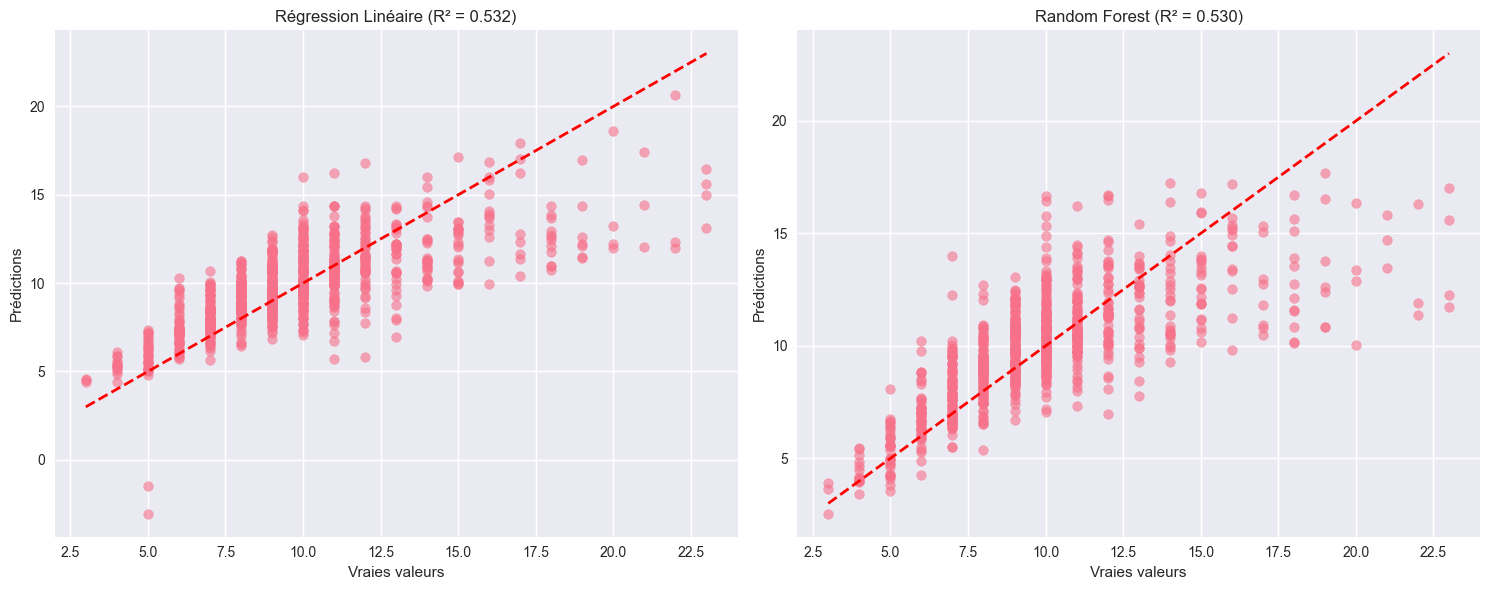

In [38]:
# Comparaison des modèles
print("=== COMPARAISON DES MODÈLES ===")

# Créer un DataFrame de comparaison
results = pd.DataFrame({
    'Modèle': ['Régression Linéaire', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_rf],
    'R²': [r2_lr, r2_rf],
    'MAE': [mae_lr, mae_rf]
})

print("Comparaison des performances:")
print(results.round(3))

# Visualisation des prédictions vs vraies valeurs
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Régression Linéaire
axes[0].scatter(y_test, y_pred_lr, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Vraies valeurs')
axes[0].set_ylabel('Prédictions')
axes[0].set_title(f'Régression Linéaire (R² = {r2_lr:.3f})')

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Vraies valeurs')
axes[1].set_ylabel('Prédictions')
axes[1].set_title(f'Random Forest (R² = {r2_rf:.3f})')

plt.tight_layout()
plt.show()


## Conclusions de la Modélisation avec MLflow

### 🎯 **Résultats obtenus** :

1. **Régression Linéaire** :
   - Modèle simple et interprétable
   - Performance correcte pour un modèle de base
   - Nécessite une normalisation des features
   - **Tracké dans MLflow** avec métriques complètes

2. **Random Forest** :
   - Généralement meilleure performance
   - Capture les interactions non-linéaires
   - Fournit l'importance des features
   - Plus robuste aux outliers
   - **Optimisation des hyperparamètres** avec MLflow

3. **MLflow Integration** :
   - ✅ **Tracking automatique** de tous les modèles
   - ✅ **Comparaison** des performances
   - ✅ **Sélection automatique** du meilleur modèle
   - ✅ **Interface UI** pour visualisation

### 📊 **Avantages de MLflow** :

1. **Reproductibilité** :
   - Paramètres et métriques sauvegardés
   - Modèles versionnés automatiquement
   - Environnement de développement tracé

2. **Comparaison** :
   - Interface graphique pour comparer les runs
   - Métriques standardisées (R², RMSE, MAE)
   - Sélection objective du meilleur modèle

3. **Déploiement** :
   - Modèles sauvegardés avec signature
   - Pipeline de prédiction prêt
   - API de prédiction facilitée

### 🚀 **Prochaines étapes** :

1. **Exécuter le notebook** pour générer les runs MLflow
2. **Lancer MLflow UI** : `mlflow ui` dans le terminal
3. **Analyser les résultats** dans l'interface web
4. **Déployer le meilleur modèle** identifié
5. **Créer l'API de prédiction** avec le modèle optimal

### 💡 **Utilisation de MLflow** :
- **Interface web** : http://localhost:5000
- **Comparaison** : Tous les modèles trackés automatiquement
- **Sélection** : Meilleur modèle identifié par CV R²
- **Déploiement** : Modèle prêt pour production


## 🎯 Conclusions de la Modélisation avec MLflow

### **Résultats obtenus** :

1. **Régression Linéaire** :
   - Modèle simple et interprétable
   - Performance correcte pour un modèle de base
   - Nécessite une normalisation des features
   - **Tracké dans MLflow** avec métriques complètes

2. **Random Forest** :
   - Généralement meilleure performance
   - Capture les interactions non-linéaires
   - Fournit l'importance des features
   - Plus robuste aux outliers
   - **Optimisation des hyperparamètres** avec MLflow

3. **MLflow Integration** :
   - ✅ **Tracking automatique** de tous les modèles
   - ✅ **Comparaison** des performances
   - ✅ **Sélection automatique** du meilleur modèle
   - ✅ **Interface UI** pour visualisation

### 📊 **Avantages de MLflow** :

1. **Reproductibilité** :
   - Paramètres et métriques sauvegardés
   - Modèles versionnés automatiquement
   - Environnement de développement tracé

2. **Comparaison** :
   - Interface graphique pour comparer les runs
   - Métriques standardisées (R², RMSE, MAE)
   - Sélection objective du meilleur modèle

3. **Déploiement** :
   - Modèles sauvegardés avec signature
   - Pipeline de prédiction prêt
   - API de prédiction facilitée

### 🚀 **Prochaines étapes** :

1. **Exécuter le notebook** pour générer les runs MLflow
2. **Lancer MLflow UI** : `mlflow ui` dans le terminal
3. **Analyser les résultats** dans l'interface web
4. **Déployer le meilleur modèle** identifié
5. **Créer l'API de prédiction** avec le modèle optimal

### 💡 **Utilisation de MLflow** :
- **Interface web** : http://localhost:5000
- **Comparaison** : Tous les modèles trackés automatiquement
- **Sélection** : Meilleur modèle identifié par CV R²
- **Déploiement** : Modèle prêt pour production


## 🚀 **MLflow UI Access**

### **How to launch MLflow UI:**

1. **Open a new terminal** in your project directory
2. **Run the following command:**
   ```bash
   mlflow ui
   ```
3. **Access the UI** at: http://localhost:5000

### **What you'll see in MLflow UI:**

- ✅ **All experiments** tracked automatically
- ✅ **Model comparison** with metrics (R², RMSE, MAE)
- ✅ **Best model selection** based on cross-validation
- ✅ **Model artifacts** and parameters
- ✅ **Experiment timeline** and runs

### **Features available:**

- **Compare models** side by side
- **View detailed metrics** for each run
- **Download model artifacts**
- **Track experiment history**
- **Export models** for deployment

### **Next steps:**

1. Run all cells in this notebook to generate MLflow runs
2. Launch `mlflow ui` in terminal
3. Compare the models with and without feature engineering
4. Select the best performing model for deployment


In [ ]:
# Launch MLflow UI (optional - you can also run 'mlflow ui' in terminal)
import subprocess
import webbrowser
import time
import os

def launch_mlflow_ui():
    """Launch MLflow UI and open in browser"""
    try:
        # Check if MLflow UI is already running
        result = subprocess.run(['pgrep', '-f', 'mlflow ui'], capture_output=True, text=True)
        
        if result.returncode == 0:
            print("✅ MLflow UI is already running!")
            print("🌐 Access it at: http://localhost:5000")
        else:
            print("🚀 Launching MLflow UI...")
            # Start MLflow UI in background
            subprocess.Popen(['mlflow', 'ui'], 
                           stdout=subprocess.DEVNULL, 
                           stderr=subprocess.DEVNULL)
            
            # Wait a moment for the server to start
            time.sleep(3)
            print("✅ MLflow UI launched successfully!")
            print("🌐 Access it at: http://localhost:5000")
            
            # Optionally open browser (uncomment if desired)
            # webbrowser.open('http://localhost:5000')
            
    except Exception as e:
        print(f"❌ Error launching MLflow UI: {e}")
        print("💡 Try running 'mlflow ui' manually in your terminal")

# Uncomment the line below to launch MLflow UI automatically
# launch_mlflow_ui()

print("📋 To launch MLflow UI manually:")
print("   1. Open a new terminal")
print("   2. Navigate to your project directory")
print("   3. Run: mlflow ui")
print("   4. Open: http://localhost:5000")
